##Cài các thư viện cần thiết với phiên bản phù hợp với board

In [ ]:
!pip install tensorflow==1.15.0
!pip install keras==2.3.1

##Kết nối đến GG drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/segmentaton

In [ ]:
import os
import cv2
filenames=os.listdir("data/")        #lấy tất cả ảnh từ folder data
labelf=os.listdir("label/")          #lấy tất cả ảnh từ folder label
filenames.sort()
labelf.sort()

labels=[]
images=[]
#đọc tất cả ảnh
for i in filenames:
    img=cv2.imread("data/{}".format(i))
    images.append(img)
#đọc tất cả label
for i in labelf:
    img = cv2.imread("label/{}".format(i))
    img=img[:,:,0]
    img=img.reshape(80, 160,1)
    labels.append(img)


In [ ]:
import numpy as np
print(np.array(labels).shape)
print(np.array(images).shape)

(682, 80, 160, 1)
(682, 80, 160, 3)


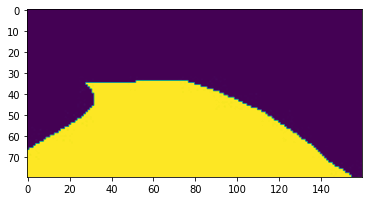

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import imageio
plt.imshow(np.array(labels[45]).reshape(80,160))      #in label xem thử

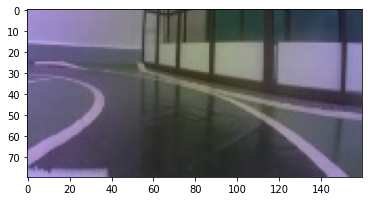

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import imageio
plt.imshow(np.array(images[45]))            #in ảnh xem thử

##Import các thư viện cần thiết để huấn luyện mô hình

In [ ]:
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, Dropout, UpSampling2D
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input
from keras.models import Model, load_model
from keras.layers.merge import concatenate
from keras import regularizers

##Hàm khởi tạo mô hình

In [ ]:
def create_model(input_shape, pool_size):
    # Create the actual neural network here
    input_img = Input(input_shape, name='img')

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)

    u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c4)
    u5 = concatenate([u5, c3])
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same') (u5)
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same') (c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c2])
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c1])
    c8 = Conv2D(8, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(8, (3, 3), activation='relu', padding='same') (c8)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c8)

    model = Model(inputs=[input_img], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy') 
    model.summary()
    return model


In [ ]:
images = np.array(images)
labels = np.array(labels)
labels = labels / 255          #đưa các giá trị output từ 0-255 về 0-1        
images, labels = shuffle(images, labels)
#chia tập dữ liệu thành 90% cho training, và 20% cho validation 
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2)

batch_size = 16     #batch size
epochs = 40         #số epochs
pool_size = (2, 2)
input_shape = X_train.shape[1:]

model = create_model(input_shape, pool_size)                #Xây dựng model

(80, 160, 3)

##data augmentation đơn giản

In [ ]:
datagen = ImageDataGenerator(channel_shift_range=0.2, brightness_range=[0.7,1.3])               #tạo ra các ảnh mới bằng cách tăng sáng và thêm tối cho ảnh

##Khởi tạo một số callback thông dụng

In [ ]:
from keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)   
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',   #điều cần quan tâm là độ chính xác nếu độ chính xác 
                                                                 #không tăng thì lr sẽ giảm
                                            patience=3,          #số lượng epoch mà sau đó không cải thiện chương trình sẽ stop
                                            verbose=1,           #có cập nhật và hiển thị trạng thái khi reduce
                                            factor=0.5,          #new_lr=factor*lr
                                            min_lr=1e-6)      #giới hạn lr
checkpoint = ModelCheckpoint('models/model-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='auto')
callb=[learning_rate_reduction,checkpoint]

##Traning

In [ ]:
#bắt đầu training
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=len(X_train)/batch_size,
    epochs=100, verbose=1, validation_data=(X_val, y_val), callbacks=callb)